In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd

nsrdb = pd.read_csv("data/nsrdb.csv", skiprows=2)

# start_time = 8500 # summer
start_time = 0 # winter

nhours = 24
dt = 0.5
h = int(24 / dt)

# link for 0.293 number convert SEER to COP
# https://www.russellshvac.com/2011/09/15/hspf-compare-the-ratings-when-youre-going-to-a-heat-pump-system
# 12.000 BTUs equal to 1 ton. That means that a 3-ton heat pump can remove 36.000 BTUs of air every hour.
# Such a heat pump needs 7.200 startup watts and 5.400 running watts.
pcool = 3.5 * 1000 * 2 # thermal [3.5 kW/ton * W/kW * tons] [kW]
pheat = 15 * 0.293 * 1000 # [kW] [15 kBtu * KBtu/kW * W/kW]

cop2hspf = 0.293
cop_heating = 8.2 * 0.293 # kW / kW # hspf = 8.2 kBtu/kW --> conversion -> COP = 0.293*hspf = [kW/kW]
cop_cooling = 20 * 0.293 # kW / kW # seer = 20 kBtu/kW --> conversion -> COP = 0.293*hspf = [kW/kW]

r = 1/60 # w/k
c = 1.5*1e7 # J/k
k = 1.3 # equivalent window area m^2 shgc ~= 0.3 (AZ) --> shgc * approx real window area

# state space matrix
b = [1/(r*c), k/c, 1/c]


 
ghi = cp.Constant(nsrdb["GHI"].loc[start_time:start_time+h-1])
tout = cp.Constant(nsrdb["Temperature"].loc[start_time:start_time+h-1])

In [2]:
tinit=22 # approx 72 deg F
tin = cp.Variable(h+1) # creates a variable that is h timesteps + 1 long -- can you see why it needs to be '+1' long?
pelec = cp.Variable(h) # is h long
sc = cp.Variable(h, integer=True) # these variables can only be integers -- that's how we represent 'on' OR 'off'
sh = cp.Variable(h, integer=True)

cons = [tin[0] == tinit,
        tin[1:] == tin[:-1] + (b[0]*(tout-tin[:-1]) + b[1]*ghi - b[2]*sc*pcool + b[2]*sh*pheat)*3600*dt,
        tin <= 25,
        tin >= 20,
        sc <= 1,
        sc >= 0,
        sh <= 1,
        sh >= 0,
        # pcool [W] / COP [kW/kW] * sc [% on/off] + pheat [W] / COP [kW/kW] * sc [% on/off] / 1000 [kW/W]
        pelec == (pcool / cop_cooling * sc + pheat / cop_heating  * sh) / 1000] # p_th -> p_elec /1000 for kW
obj = cp.Minimize(cp.sum(pelec))

prob = cp.Problem(obj, cons)
prob.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-03


9.146341463414636

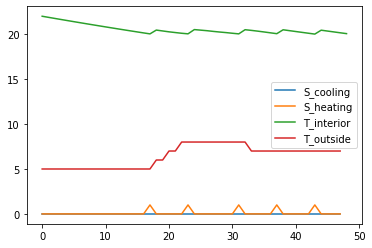

In [3]:
plt.plot(sc.value, label="S_cooling")
plt.plot(sh.value, label="S_heating")
plt.plot(tin.value, label="T_interior")
plt.plot(tout.value, label="T_outside")
plt.legend()

In [4]:
# challenge, create an MPC optimization that runs for a week
ntimesteps = int(7 * 24 / dt)
for _ in range(ntimesteps):
    start_time += 1

TypeError: 'int' object is not iterable